The [second place solution](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/543766) was done by [Omid Baghcheh Saraei](https://www.kaggle.com/omidbaghchehsaraei). The notebook is shown below.

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [1]:
!pip install -q hillclimbers

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from hillclimbers import climb_hill, partial
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

oof = {}
test_pred = {}
NUM_FOLD = 5
target = 'loan_status'

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Data</p>

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

In [4]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [6]:
original.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<Figure size 800x500 with 0 Axes>

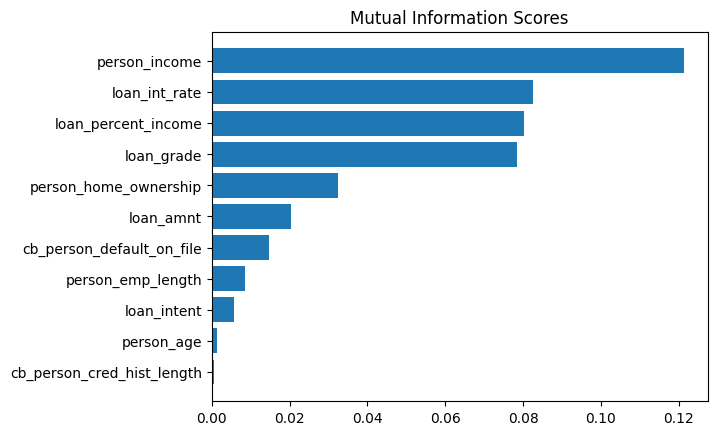

<Figure size 800x500 with 0 Axes>

In [7]:
X_ = train.copy()
y_ = X_.pop("loan_status")

for col in X_.select_dtypes("object"):
    X_[col], _ = X_[col].factorize()

discrete_features = X_.dtypes == int

mi_scores = mutual_info_classif(X_, y_, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_.columns)
mi_scores = mi_scores.sort_values(ascending=True)

width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))

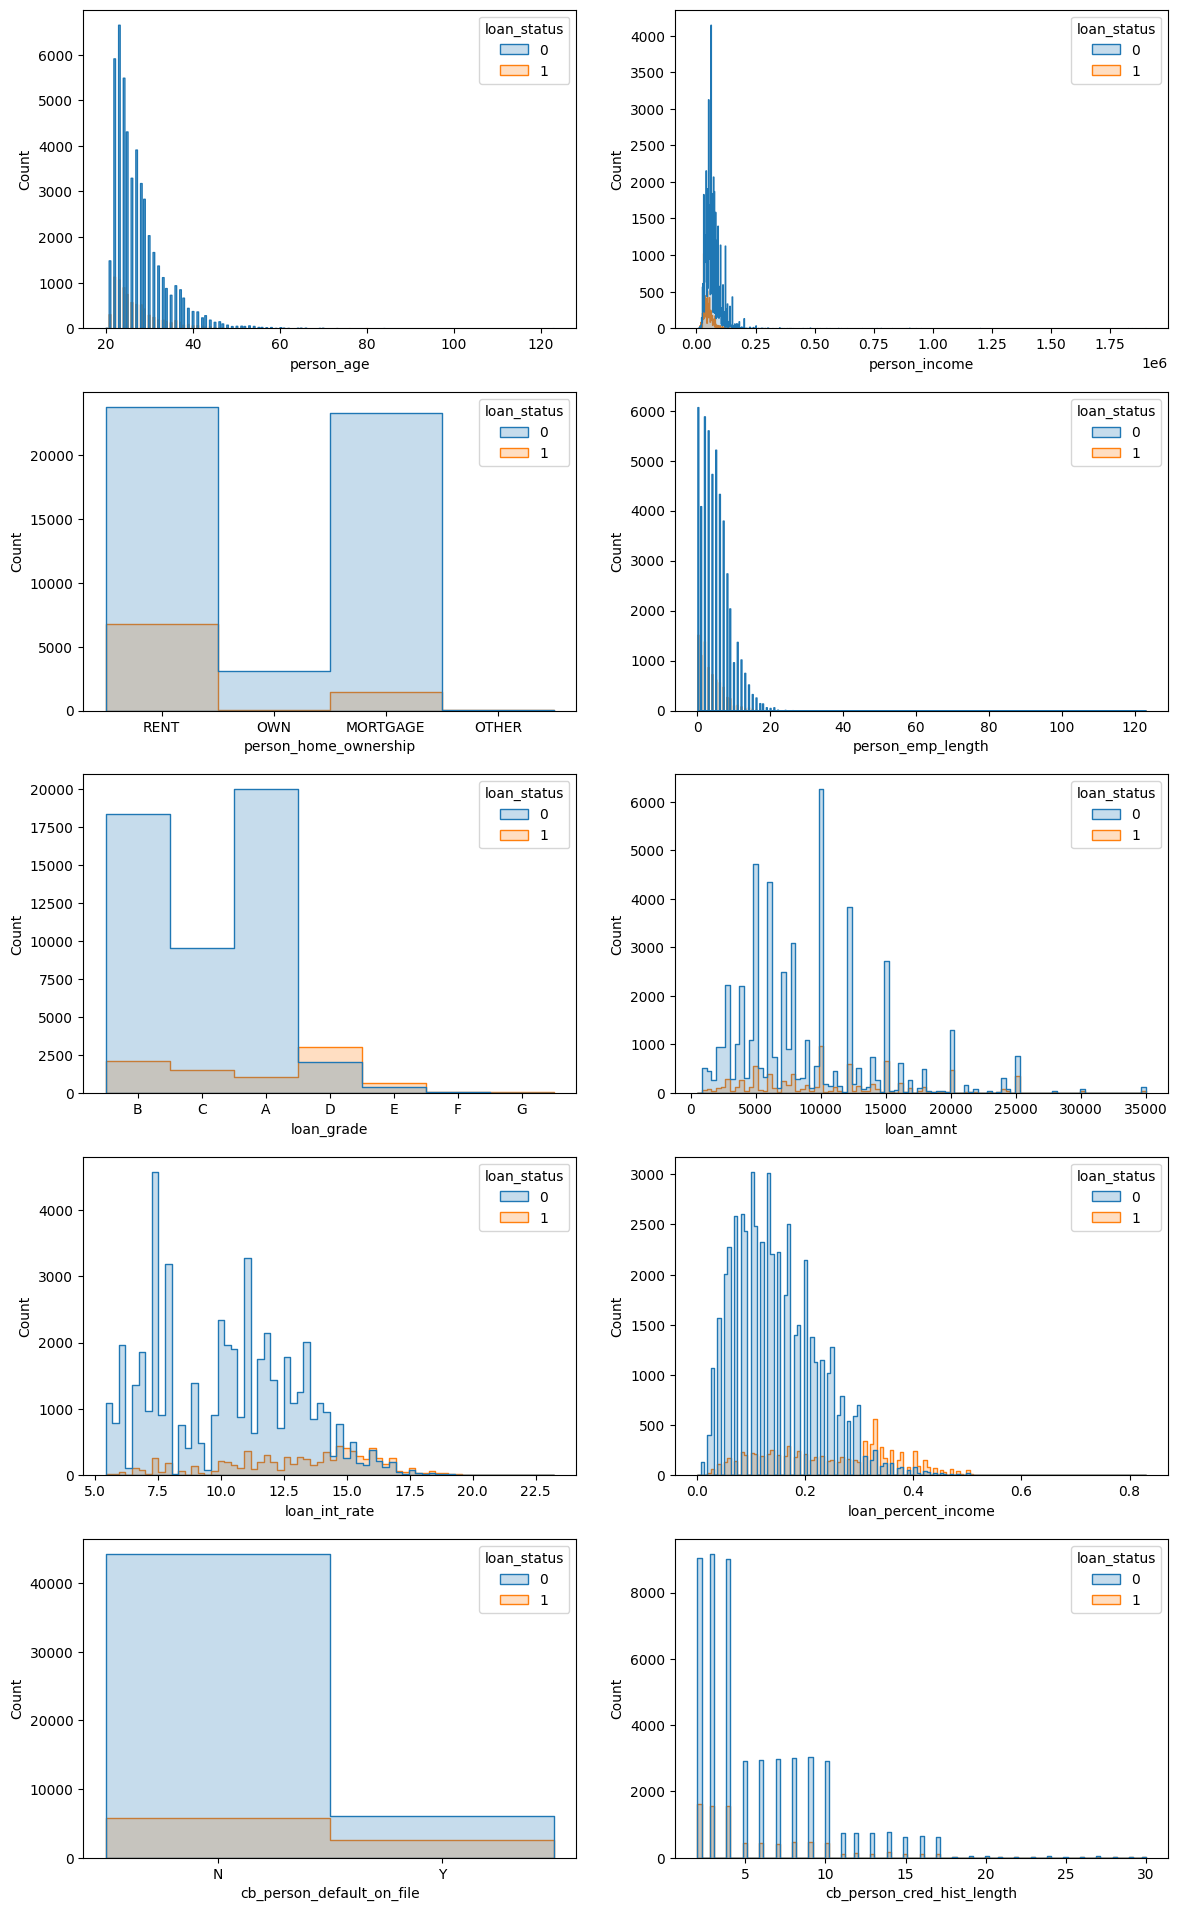

In [8]:
f, axes = plt.subplots(5, 2, figsize=(14, 24)) 
col = test.columns.tolist()
col.remove('loan_intent')
j = 0
for i in range(0, 10, 2):
    sns.histplot(data=train, x=col[i], element="step", hue="loan_status", ax=axes[j, 0]) 
    sns.histplot(data=train, x=col[i+1], element="step", hue="loan_status", ax=axes[j, 1])
    j = j + 1

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Cross Validation</p>

In [9]:
def cross_validation(model, label):
    
    train_copy, test_copy, original_copy = train.copy(), test.copy(), original.copy()
    
    if label in ['cb', 'et', 'rf', 'knn', 'mlp']:
        cat_cols = test_copy.columns.tolist()
        for df in [train_copy, test_copy, original_copy]:
            for col in cat_cols:  
                df[col] = df[col].astype('str').astype('category')
        
    elif label in ['xgb', 'lgbm', 'dart', 'goss']: 
        cat_cols = list(test_copy.select_dtypes(include=['object']).columns)
        for df in [train_copy, test_copy, original_copy]:
            for col in cat_cols:  
                df[col] = df[col].astype('str').astype('category')
                
    X = train_copy.drop([target], axis=1)
    y = train_copy[target]
    X_original = original_copy.drop([target], axis=1)
    y_original = original_copy[target]
        

    val_scores = []
    test_preds_model = []
    oof_model = np.zeros(len(train),)
    
    skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=1)

    for Fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        X_train = pd.concat([X_train, X_original], axis=0)
        y_train = pd.concat([y_train, y_original]) 
    
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_val)[:, 1]
    
        roc_auc_score_ = roc_auc_score(y_val, y_pred)
    
        print(f'Fold {Fold}: roc_auc_score= {roc_auc_score_:.5f}')
    
        val_scores.append(roc_auc_score_)
        
        oof_model[val_index] = y_pred
        
        test_preds_model.append(model.predict_proba(test_copy)[:, 1])
    
    oof[label] = oof_model
    
    test_preds_model = sum(test_preds_model)/len(test_preds_model)
    test_pred[label] = test_preds_model 

    print(f'mean validation roc_auc_score = {np.mean(val_scores):.5f}')
    print(f'std validation roc_auc_score = {np.std(val_scores):.5f}')
    
    plt.figure(figsize=(10, 4))
    plt.suptitle(label, y=1.0, fontsize=20)
    ax = plt.subplot(1, 2, 1)
    plt.title('Calibration')
    CalibrationDisplay.from_predictions(y, oof_model, n_bins=10, strategy='quantile', ax=ax)
    plt.subplot(1, 2, 2)
    plt.title('Histogram')
    plt.hist(oof_model, bins=10)
    plt.show()

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Lightgbm</p>

Fold 0: roc_auc_score= 0.96538
Fold 1: roc_auc_score= 0.96292
Fold 2: roc_auc_score= 0.96582
Fold 3: roc_auc_score= 0.96499
Fold 4: roc_auc_score= 0.96296
mean validation roc_auc_score = 0.96441
std validation roc_auc_score = 0.00123


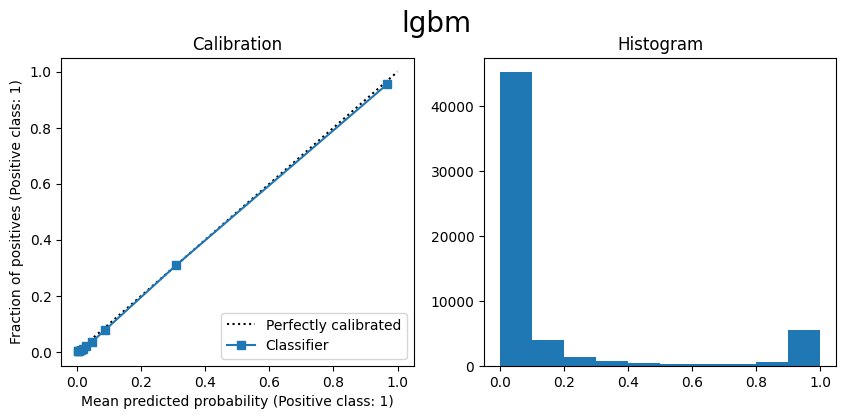

CPU times: user 6min 5s, sys: 7.55 s, total: 6min 13s
Wall time: 5min 54s


In [10]:
%%time

params_lgbm = {
    
    'verbose': -1,
    'random_state': 1,
    'objective': 'binary',
    'n_estimators': 4100,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 8,
    'max_bin': 5000,
}

model_1 = LGBMClassifier(**params_lgbm)

cross_validation(model_1, 'lgbm')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Dart</p>

Fold 0: roc_auc_score= 0.96515
Fold 1: roc_auc_score= 0.96207
Fold 2: roc_auc_score= 0.96602
Fold 3: roc_auc_score= 0.96367
Fold 4: roc_auc_score= 0.96256
mean validation roc_auc_score = 0.96389
std validation roc_auc_score = 0.00150


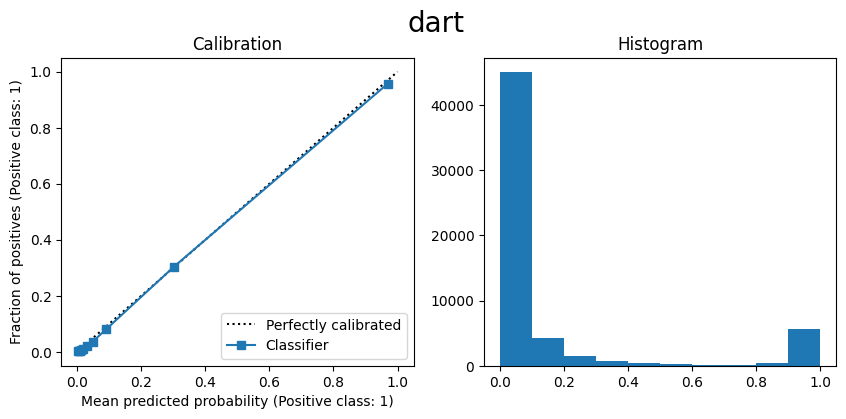

CPU times: user 17min 37s, sys: 354 ms, total: 17min 38s
Wall time: 17min 43s


In [11]:
%%time

params_dart = {
    
    'verbose': -1,
    'random_state': 1,
    'boosting': 'dart',
    'n_estimators': 600,
    'learning_rate': 0.1,
    'colsample_bytree': 0.6,
    'num_leaves': 85,
    'min_data_in_leaf': 30,
    'max_bin': 1995,
    'objective': 'binary',
}

model_2 = LGBMClassifier(**params_dart)

cross_validation(model_2, 'dart')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">XGBoost</p>

Fold 0: roc_auc_score= 0.96602
Fold 1: roc_auc_score= 0.96454
Fold 2: roc_auc_score= 0.96718
Fold 3: roc_auc_score= 0.96609
Fold 4: roc_auc_score= 0.96423
mean validation roc_auc_score = 0.96561
std validation roc_auc_score = 0.00109


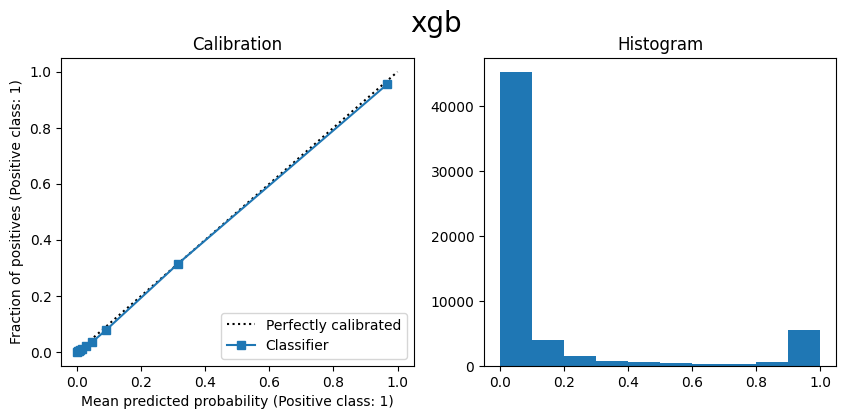

CPU times: user 10min 11s, sys: 3.56 s, total: 10min 15s
Wall time: 10min 17s


In [12]:
%%time

params_xgb = {
    
    'enable_categorical': True,
    'random_state': 1,
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'reg_lambda': 0.01,
    'max_depth': 4,
    'max_bin': 5000,
    'subsample': 0.95,
    'reg_alpha': 0.1,
 
}

model_3 = XGBClassifier(**params_xgb)

cross_validation(model_3, 'xgb')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">ExtraTrees</p>

Fold 0: roc_auc_score= 0.96536
Fold 1: roc_auc_score= 0.96393
Fold 2: roc_auc_score= 0.96452
Fold 3: roc_auc_score= 0.96477
Fold 4: roc_auc_score= 0.96365
mean validation roc_auc_score = 0.96445
std validation roc_auc_score = 0.00061


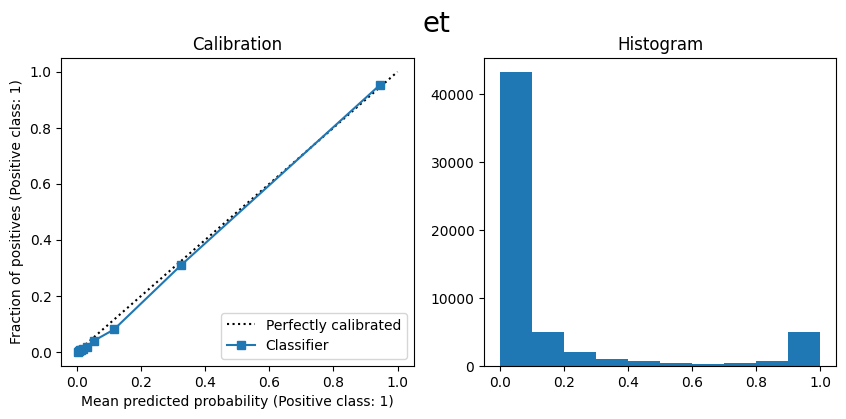

CPU times: user 4min 5s, sys: 581 ms, total: 4min 5s
Wall time: 4min 6s


In [13]:
%%time

params_et = {
    
    'random_state': 1,
    'n_estimators': 470,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'criterion': 'log_loss',
}

model_4 = make_pipeline(TargetEncoder(), ExtraTreesClassifier(**params_et))

cross_validation(model_4, 'et')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Random Forest</p>

Fold 0: roc_auc_score= 0.96508
Fold 1: roc_auc_score= 0.96277
Fold 2: roc_auc_score= 0.96362
Fold 3: roc_auc_score= 0.96442
Fold 4: roc_auc_score= 0.96212
mean validation roc_auc_score = 0.96360
std validation roc_auc_score = 0.00107


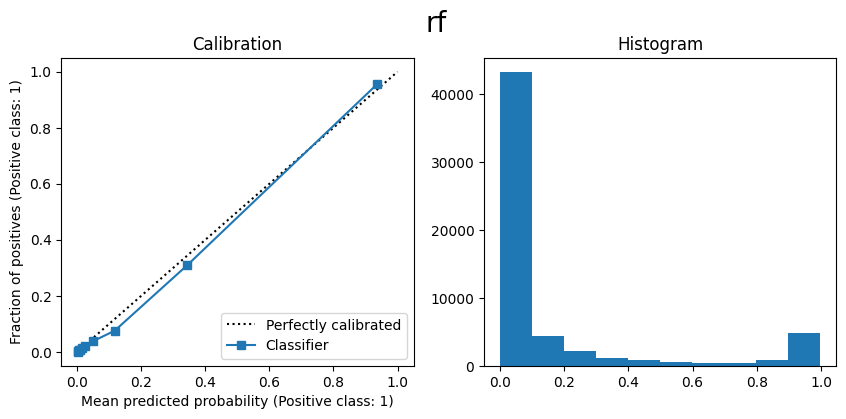

CPU times: user 5min 13s, sys: 353 ms, total: 5min 14s
Wall time: 5min 15s


In [14]:
%%time

params_rf = {
    
    'random_state': 1,
    'n_estimators': 450,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 960,
    'criterion': 'entropy',
}

model_5 = make_pipeline(TargetEncoder(), RandomForestClassifier(**params_rf))

cross_validation(model_5, 'rf')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">CatBoost</p>

Fold 0: roc_auc_score= 0.96991
Fold 1: roc_auc_score= 0.96671
Fold 2: roc_auc_score= 0.96894
Fold 3: roc_auc_score= 0.97020
Fold 4: roc_auc_score= 0.96734
mean validation roc_auc_score = 0.96862
std validation roc_auc_score = 0.00138


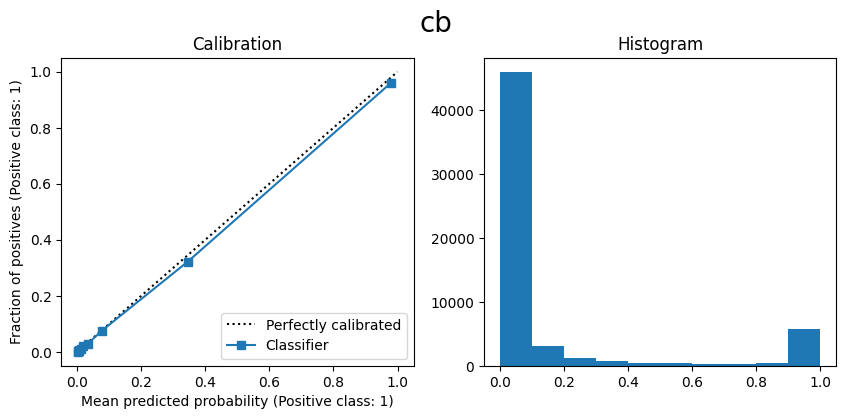

CPU times: user 1h 39min 20s, sys: 3min 24s, total: 1h 42min 45s
Wall time: 27min 24s


In [15]:
%%time

params_cb = {
    
    'verbose': False,
    'random_state': 1,
    'task_type': 'CPU',
    'cat_features' : test.columns.tolist(),
    'min_data_in_leaf': 5,
    'n_estimators': 1800,
    'random_strength': 0.79,
    'depth': 8,
    'bagging_temperature': 0.6,
    'l2_leaf_reg': 4,
    'rsm': 0.6,
}

model_6 = CatBoostClassifier(**params_cb)

cross_validation(model_6, 'cb')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">KNeighbors</p>

Fold 0: roc_auc_score= 0.95854
Fold 1: roc_auc_score= 0.95563
Fold 2: roc_auc_score= 0.95864
Fold 3: roc_auc_score= 0.95684
Fold 4: roc_auc_score= 0.95586
mean validation roc_auc_score = 0.95710
std validation roc_auc_score = 0.00128


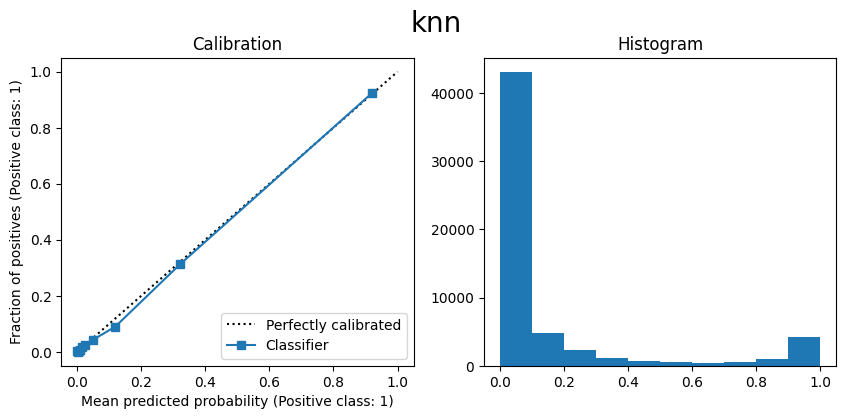

CPU times: user 5min 24s, sys: 2.45 s, total: 5min 26s
Wall time: 5min 28s


In [16]:
%%time

model_7 = make_pipeline(TargetEncoder(), KNeighborsClassifier(n_neighbors=185, 
                                                              metric='manhattan',
                                                              weights='distance'))

cross_validation(model_7, 'knn')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">MLP</p>

Fold 0: roc_auc_score= 0.96200
Fold 1: roc_auc_score= 0.95869
Fold 2: roc_auc_score= 0.96128
Fold 3: roc_auc_score= 0.96212
Fold 4: roc_auc_score= 0.95948
mean validation roc_auc_score = 0.96072
std validation roc_auc_score = 0.00138


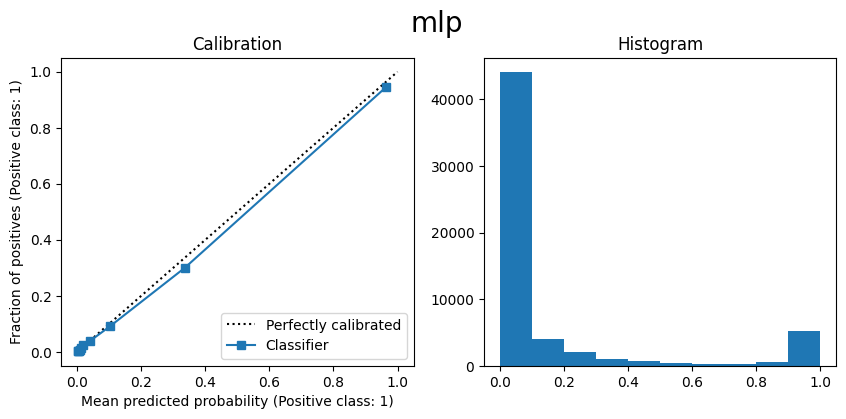

CPU times: user 3min 12s, sys: 2.29 s, total: 3min 14s
Wall time: 3min 12s


In [17]:
%%time

params_mlp = {
    
    'random_state': 1,
    'hidden_layer_sizes': (32, 3),
    
}

model_8 = make_pipeline(TargetEncoder(), StandardScaler(), MLPClassifier(**params_mlp))

cross_validation(model_8, 'mlp')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Goss</p>

Fold 0: roc_auc_score= 0.96554
Fold 1: roc_auc_score= 0.96354
Fold 2: roc_auc_score= 0.96592
Fold 3: roc_auc_score= 0.96530
Fold 4: roc_auc_score= 0.96346
mean validation roc_auc_score = 0.96475
std validation roc_auc_score = 0.00104


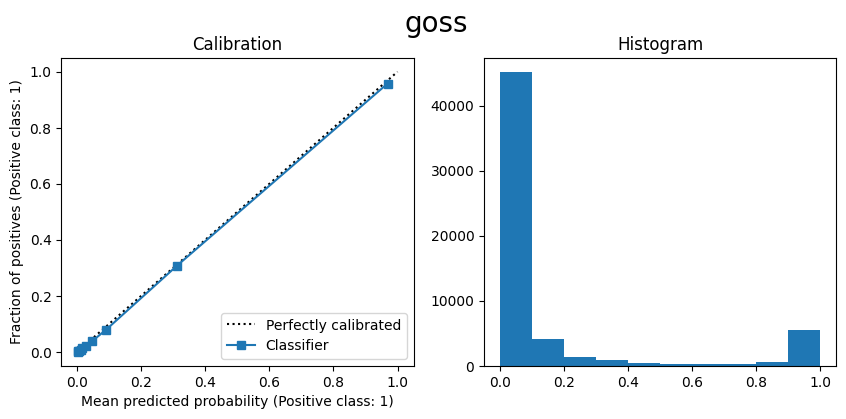

CPU times: user 7min 42s, sys: 352 ms, total: 7min 42s
Wall time: 7min 44s


In [18]:
%%time

params_goss = {
    
    'verbose': -1,
    'random_state': 1,
    'data_sample_strategy': 'goss',
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 17,
    'max_bin': 4000,
}

model_9 = LGBMClassifier(**params_goss)

cross_validation(model_9, 'goss')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">ECDF Plot</p>

<Axes: ylabel='Proportion'>

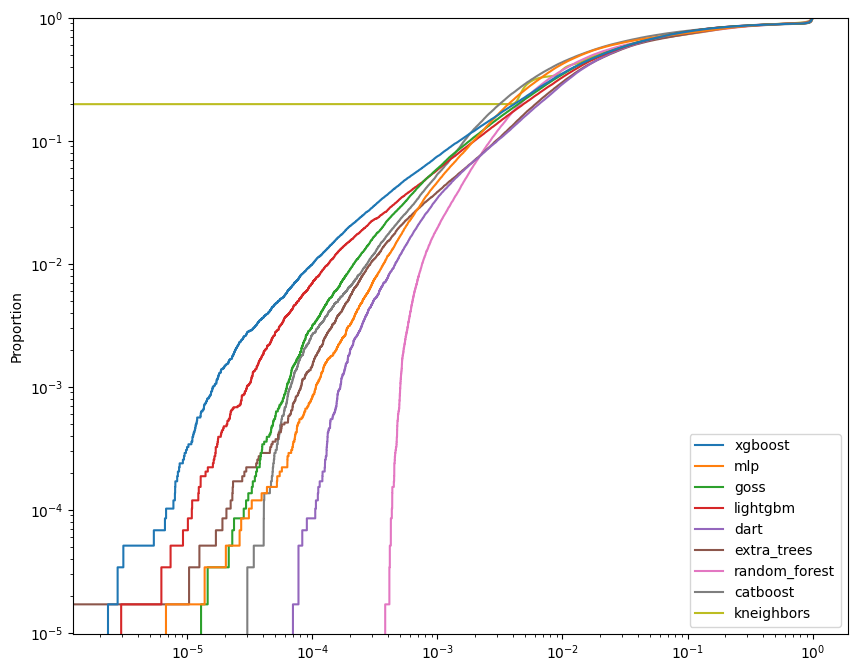

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xscale="log", yscale="log")
sns.ecdfplot(pd.DataFrame({'xgboost': oof['xgb'], 'mlp': oof['mlp'], 'goss': oof['goss'],
                           'lightgbm': oof['lgbm'], 'dart': oof['dart'],
                           'extra_trees': oof['et'], 'random_forest': oof['rf'], 
                           'catboost': oof['cb'],'kneighbors': oof['knn']}), ax=ax)

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">(Logistic Regression) Ensemble</p>

In [20]:
ensemble_fold_scores = []
ensemble_test_preds = []

y_ensemble = train[target]
X_ensemble = pd.DataFrame(oof)    
x_test_ensemble = pd.DataFrame(test_pred)

skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=1)

for i, (train_index_ens, val_index_ens) in enumerate(skf.split(X_ensemble, y_ensemble)):
    
    X_train_ens, X_val_ens = X_ensemble.iloc[train_index_ens], X_ensemble.iloc[val_index_ens]
    y_train_ens, y_val_ens = y_ensemble[train_index_ens], y_ensemble[val_index_ens]
    
    lr = LogisticRegression().fit(X_train_ens, y_train_ens)
    
    ensemble_val_pred = lr.predict_proba(X_val_ens)[:, 1] 
    
    ensemble_roc_auc_score = roc_auc_score(y_val_ens, ensemble_val_pred)
    ensemble_fold_scores.append(ensemble_roc_auc_score)
    
    print('Fold', i, '==> roc_auc_score (LR ensemble) is ==>', ensemble_roc_auc_score)
    
    ensemble_test_preds.append(lr.predict_proba(x_test_ensemble)[:, 1])
    
ensemble_test_preds = sum(ensemble_test_preds)/len(ensemble_test_preds)

print(f'\nCV roc_auc_score = {np.mean(ensemble_fold_scores):.5f}')
print(f'\nstd roc_auc_score = {np.std(ensemble_fold_scores):.5f}')

Fold 0 ==> roc_auc_score (LR ensemble) is ==> 0.970230549935024
Fold 1 ==> roc_auc_score (LR ensemble) is ==> 0.9668223350495548
Fold 2 ==> roc_auc_score (LR ensemble) is ==> 0.969353687495275
Fold 3 ==> roc_auc_score (LR ensemble) is ==> 0.9698781381466117
Fold 4 ==> roc_auc_score (LR ensemble) is ==> 0.9678433172426396

CV roc_auc_score = 0.96883

std roc_auc_score = 0.00129


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Hill climbing</p>

In [21]:
hc_test, hc_oof = climb_hill(train=train, target=target, objective='maximize', 
                             eval_metric=partial(roc_auc_score),oof_pred_df= X_ensemble, 
                             test_pred_df= x_test_ensemble,plot_hill=True,plot_hist=False, 
                             precision=0.001,negative_weights=True,return_oof_preds=True)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (9 total): 

cb:   0.96860 (best solo model)
xgb:  0.96560
goss: 0.96473
et:   0.96444
lgbm: 0.96440
dart: 0.96387
rf:   0.96355
mlp:  0.96062
knn:  0.95707

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: xgb | Best weight: 0.333 | Best roc_auc_score: 0.96956
Iteration: 2 | Model added: rf | Best weight: 0.085 | Best roc_auc_score: 0.96969
Iteration: 3 | Model added: knn | Best weight: -0.036 | Best roc_auc_score: 0.96973
Iteration: 4 | Model added: dart | Best weight: 0.058 | Best roc_auc_score: 0.96975
Iteration: 5 | Model added: et | Best weight: 0.043 | Best roc_auc_score: 0.96977
Iteration: 6 | Model added: mlp | Best weight: -0.033 | Best roc_auc_score: 0.96979
Iteration: 7 | Model added: lgbm | Best weight: -0.060 | Best roc_auc_score: 0.96981


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Submission</p>

In [22]:
sample_submission[target] = hc_test
sample_submission.head()

,id,loan_status
0,58645,0.996653
1,58646,0.025982
2,58647,0.482991
3,58648,0.005612
4,58649,0.033283


In [23]:
sample_submission.to_csv('submission.csv', index=False) 